# Demo for CG-SENSE Reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from sigpy.mri.sim import birdcage_maps
from scipy.ndimage import label

from cg_sense import *

np.random.seed(0)

### Utils

In [2]:
def set_background_sensitivity_to_zero(csm, image_gt):
    image_copy = image_gt.copy()
    image_copy[100:300, 100:300] = 1
    labelmap, _ = label(image_copy > 0)
    fg = labelmap != 0
    csm = fg * csm
    return csm, fg

def generate_sampling_mask(size, sample_fraction=0.5, sampling_scheme='variable-density', sampling_dim_option='1D'):

    num_rows, num_cols = size
    mask = np.zeros((num_rows, num_cols))
    
    if sampling_dim_option == '1D':

        if sampling_scheme == 'uniform':
            pmf = None
        
        elif sampling_scheme == 'variable-density':

            center_fraction = 0.08
            assert sample_fraction > center_fraction

            num_center_cols = int(center_fraction * num_cols)
            center_cols_range = (num_cols // 2 - num_center_cols // 2,  num_cols // 2 + num_center_cols // 2)
            mask[:, center_cols_range[0] : center_cols_range[1]] = 1
            
            pmf = np.ones(num_cols)
            pmf[center_cols_range[0] : center_cols_range[1]] = 0
            pmf = pmf / pmf.sum()
            
            sample_fraction = sample_fraction - center_fraction

        num_sample_lines = int(sample_fraction * num_cols)
        sampled_lines = np.random.choice(np.arange(num_cols), size=num_sample_lines, replace=False, p=pmf)        
        mask[:, sampled_lines] = 1

    elif sampling_dim_option == '2D':

        if sampling_scheme == 'uniform':
            pmf = None
        
        elif sampling_scheme == 'variable-density':
            # TODO
            pass
        
        grid_i, grid_j = np.meshgrid(np.arange(num_rows), np.arange(num_cols), indexing='ij')
        kspace_coords = np.stack((grid_i.flatten(), grid_j.flatten()), axis=1)
        num_samples = int(sample_fraction * (num_rows * num_cols))
        idxs = np.random.choice(np.arange(num_rows * num_cols), size=num_samples, replace=False, p=pmf)
        sampled_coords = kspace_coords[idxs]
        mask[sampled_coords[:, 0], sampled_coords[:, 1]] = 1

    return mask.astype(bool)

def rss_combine(coil_images):
    return np.sqrt(np.sum(coil_images ** 2, axis=0))

def imshow(ndarray, ax=None, title=''):
    show = False
    if ax is None:
        show = True
        ax = plt.gca()
    ax.imshow(np.squeeze(ndarray), cmap='gray')
    ax.set_axis_off()
    ax.set_title(title)
    if show: plt.show()

### Load data

In [3]:
# Settings

NUM_COILS = 5
ACCELERATION = 4

1.0


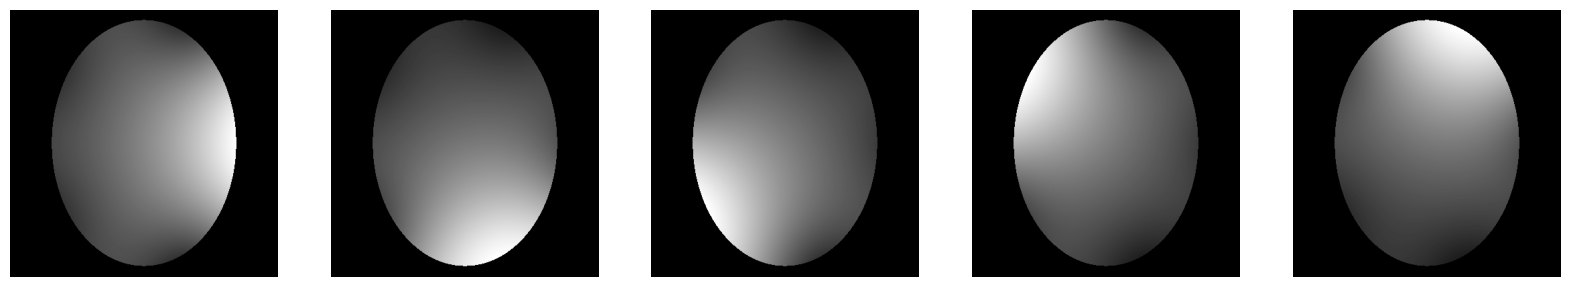

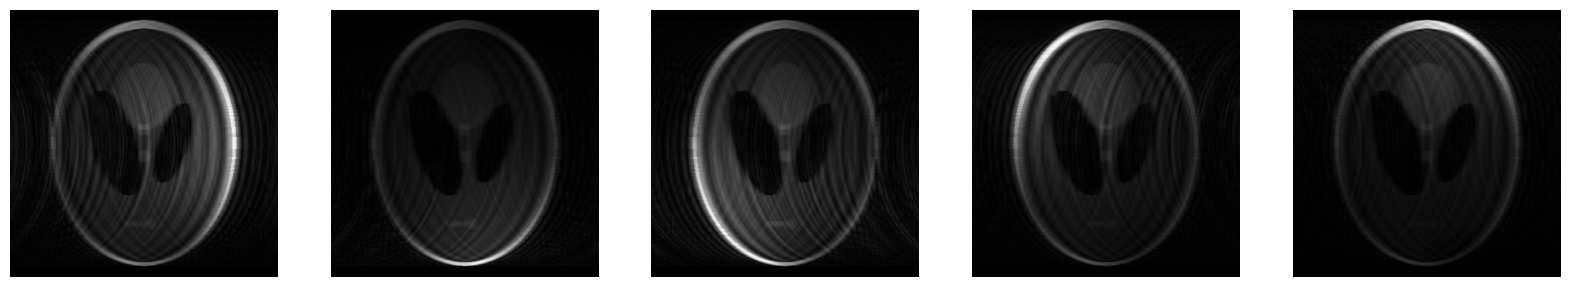

In [8]:
image_gt = shepp_logan_phantom().astype(np.float64)  # Shape format (H,W)
print(image_gt.max())

# Simulate CSMs
csm = birdcage_maps((NUM_COILS, 400, 400), r=1.1, dtype=np.complex128)  # Shape format (C,H,W)

# Estimate foreground mask and restrict CSMs to foreground
csm, fg = set_background_sensitivity_to_zero(csm, image_gt)

# Display CSMs
fig, axs = plt.subplots(1, NUM_COILS, figsize=(NUM_COILS*4, 4))
for c in range(NUM_COILS):
    imshow(np.abs(csm[c, :, :]), ax=axs[c])
plt.show()

# Simulate multi-coil undersampled data
mask = generate_sampling_mask(tuple(image_gt.shape), 1 / ACCELERATION)
mask = np.expand_dims(mask, axis=0)
mask = np.repeat(mask, NUM_COILS, axis=0)
kspace_data = fft2c(image_gt * csm) * mask
kspace_data = kspace_data + np.random.randn(*kspace_data.shape) * 0.1

coil_images = ifft2c(kspace_data)  # Shape format (C,H,W)
fig, axs = plt.subplots(1, NUM_COILS, figsize=(NUM_COILS*4, 4))
for c in range(NUM_COILS):
    imshow(np.abs(coil_images[c, :, :]), ax=axs[c])
plt.show()

### Reconstruction

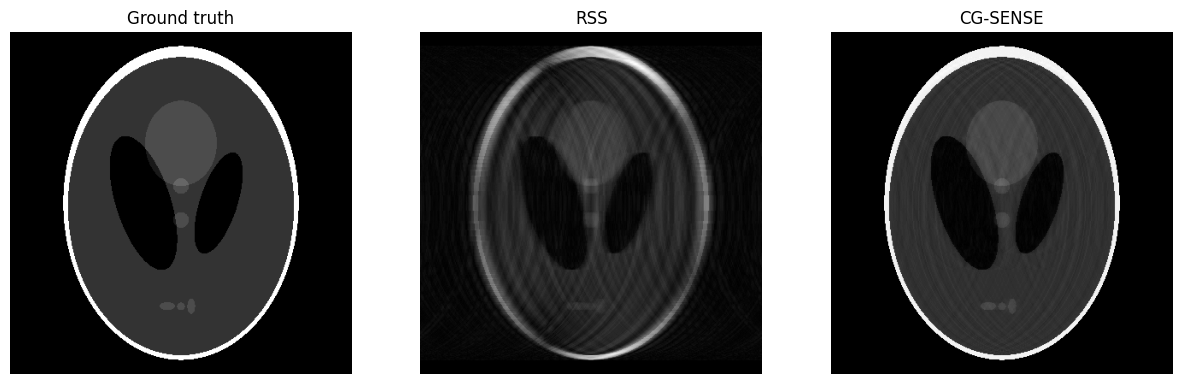

In [10]:
# RSS recon (baseline)
image_rss = rss_combine(ifft2c(kspace_data))

# CG-SENSE recon
image_sense = cg_sense(kspace_data, csm, mask, eps=1e-7)

# Display
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
imshow(np.abs(image_gt), axs[0], "Ground truth")
imshow(np.abs(image_rss), axs[1], "RSS")
imshow(np.abs(image_sense), axs[2], "CG-SENSE")